In [1]:
%pylab inline

from importlib import reload

import os
import torch
from torch import nn
import skimage.io
import zipfile

from torchinfo import summary
from torch.utils.data import Dataset

from torchvision import transforms
from tqdm.auto import tqdm

import dataset, config, model, trainer, fileloader, util

from torchinfo import summary
from torch.utils.data import Dataset, DataLoader

import tifffile

Populating the interactive namespace from numpy and matplotlib


filepath: D:\PublicTestData\epfl\CElegans-FITC.zip, frames: 1, image shape: (1, 212, 172, 34)
0:	 [id = 0],


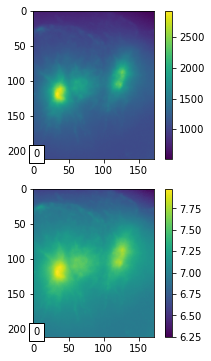

In [2]:
reload(dataset)
reload(model.encoder)
reload(model.base)
reload(model)

celegans_cy3 = os.path.join(config.config["TEST_DATASET_PATH"]["epfl"], "CElegans-FITC.zip")
training_data = dataset.FileWrapperDataset(celegans_cy3, fileloader.ZipSkImageFileLoader, slices=(slice(125, -375),slice(250, -250),slice(35,-35)), stack_to_volume=True, cache=False)
# training_data = dataset.FileWrapperDataset(celegans_cy3, fileloader.ZipSkImageFileLoader, slices=(slice(250,-250),slice(250,-250),slice(35,-35)), stack_to_volume=True, cache=False)

dataset.inspect_images(training_data)

train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)


(312, 272, 104)


C:\Users\kkc29\AppData\Local\Temp\1/ipykernel_70916/2474660506.py:9: RuntimeWarning: divide by zero encountered in log10
  axes[0].imshow(np.log10(psf[:,:,psf.shape[2]//2]))
C:\Users\kkc29\AppData\Local\Temp\1/ipykernel_70916/2474660506.py:10: RuntimeWarning: divide by zero encountered in log10
  axes[1].imshow(np.log10(psf[:,psf.shape[1]//2,:]))
C:\Users\kkc29\AppData\Local\Temp\1/ipykernel_70916/2474660506.py:11: RuntimeWarning: divide by zero encountered in log10
  axes[2].imshow(np.log10(psf[psf.shape[0]//2,:,:]))


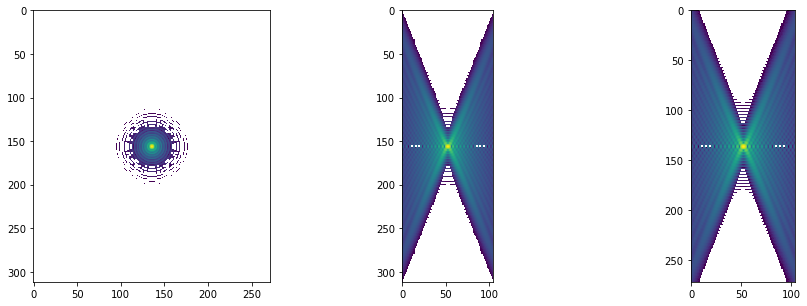

In [3]:
psf_cy3 = os.path.join(config.config["TEST_DATASET_PATH"]["epfl"], "PSF-CElegans-FITC.zip")
psf_file = fileloader.ZipSkImageFileLoader(psf_cy3, (slice(200,-200),slice(200,-200),slice(None)), True, True)

psf = psf_file[0][0]
psf /= psf.sum()
print(psf.shape)

fig, axes = subplots(1, 3, figsize=(15,5))
axes[0].imshow(np.log10(psf[:,:,psf.shape[2]//2]))
axes[1].imshow(np.log10(psf[:,psf.shape[1]//2,:]))
axes[2].imshow(np.log10(psf[psf.shape[0]//2,:,:]))

(1, 212, 172, 34) (312, 272, 104)
max_psf_count, params_ref_no_scale ignored


C:\Users\kkc29\Anaconda3\envs\smlm-dl\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


Layer (type (var_name))                  Output Shape              Param #
BaseFitModel                             --                        --
├─IdEncoderModel (encoder)               [1, 1, 412, 372, 234]     --
│    └─ModuleDict (encoders)             --                        --
│    │    └─Linear (scale)               [1, 35863776]             35,863,776
│    │    └─ViewModule (view)            [1, 1, 412, 372, 234]     --
├─DirectImageMapperModel (mapper)        [1, 1, 412, 372, 234]     --
├─ConvolutionRenderer (renderer)         [1, 1, 212, 172, 34]      35,863,777
Total params: 71,727,553
Trainable params: 71,727,553
Non-trainable params: 0
Total mult-adds (M): 35.86
Input size (MB): 0.00
Forward/backward pass size (MB): 296.83
Params size (MB): 286.91
Estimated Total Size (MB): 583.74
input shape: (1, 1, 212, 172, 34), output_shape: (1, 1, 212, 172, 34)


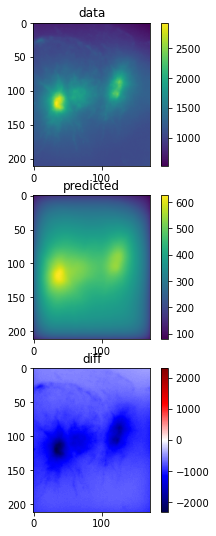

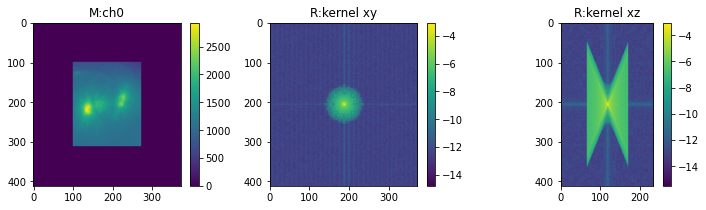

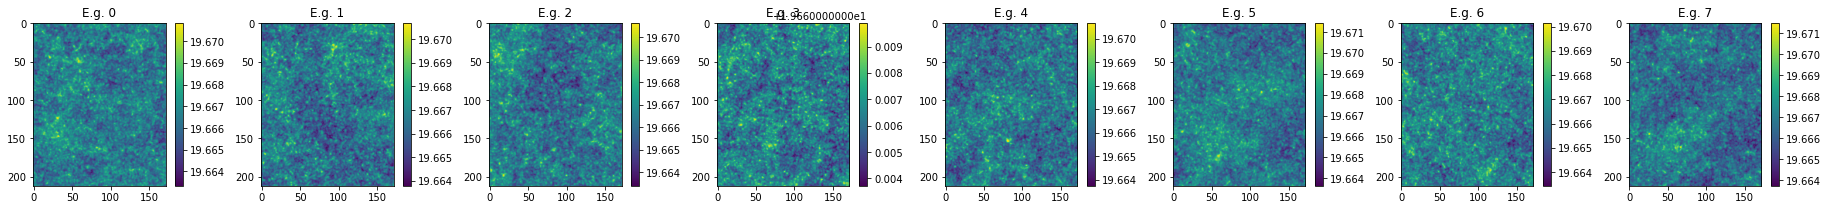

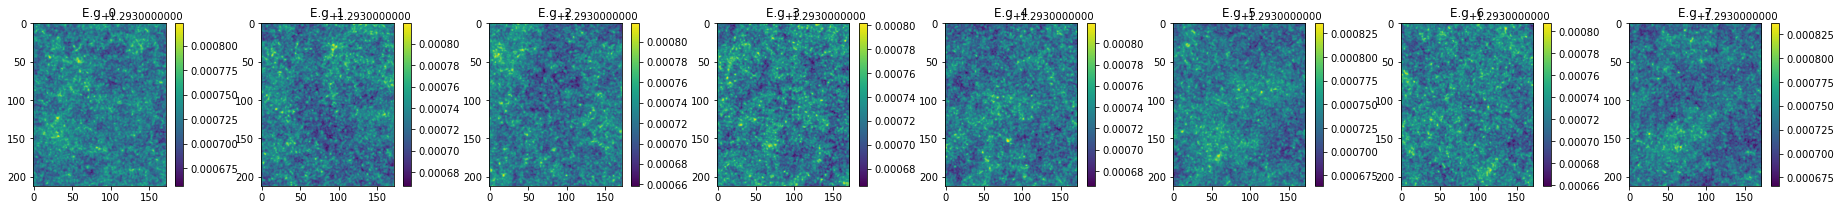

In [4]:
reload(util)
reload(model.renderer)
reload(model.mapper)
reload(model.base)
reload(model.encoder)
reload(model)
reload(trainer)

# params_ref_override = {'ch0': model.FitParameter(nn.Identity(), 0, 1, 0, False),
#                       }


print(training_data[0][0].shape, psf.shape)

fitting_model = model.BaseFitModel(encoder_class=model.IdEncoderModel,
                                   # renderer_class=model.Gaussian2DRenderer,
                                   renderer_class=model.renderer.ConvolutionRenderer,
                                   # mapper_class=model.mapper.DirectMapperModel,
                                   mapper_class=model.mapper.DirectImageMapperModel,
                                      # img_size=training_data[0][0].shape[1:],
                                       # img_size=psf.shape,
                                   img_size=(412, 372, 234),
                                      fit_params=['ch0', ],
                                      max_psf_count=1,
                                   # params_ref_override=params_ref_override,
                                      encoder_params={'num_img': len(training_data),
                                                      # 'last_out_channels': 2,
                                                      # 'out_img_shape': training_data[0][0].shape[1:],
                                                      # 'out_img_shape': psf.shape,
                                                      'out_img_shape': (412, 372, 234),
                                                      # 'init_weights': training_data[0][0],
                                                      # 'init_weights': deconv[None,None,...],
                                                      'init_weights': np.pad(training_data[0][0][0], ((100,100),(100,100),(100,100)))
                                                     },
                                   renderer_params={"kernel": psf,
                                                    # "cal_size": (412, 372, 134),
                                                   # "out_size": training_data[0][0].shape[1:],
                                                    # "cal_size": (412, 372, 234),
                                                    "out_size": training_data[0][0].shape[1:],
                                                   }
                                   
                                     )

print(summary(fitting_model, input_size=(1,), row_settings=["var_names"], depth=4))

model.check_model(fitting_model, train_dataloader)

In [5]:
lr = 1e-1 * training_data[0][0].max()
optim_params = [{'params': fitting_model.encoder.parameters()},
                {'params': [fitting_model.renderer.background], 'lr': lr},
                {'params': [fitting_model.renderer.kernel_fft], 'lr': 0},
               ]

optimizer = torch.optim.Adam(optim_params, lr=lr)

training = trainer.FittingTrainer(fitting_model, train_dataloader, optimizer=optimizer)
training.train_and_validate(10, 1, 10)

No validation data supplied. Remember to set prior to training.
CUDA not available. Defaulting to CPU
Device: cpu
Saved to : F:\Pytorch\runs\2022-02-05_17-46-21_MW1E008F61\model.ptm


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

C:\Users\kkc29\Anaconda3\envs\smlm-dl\lib\site-packages\torch\autograd\__init__.py:154: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ..\aten\src\ATen\native\Copy.cpp:244.)
  Variable._execution_engine.run_backward(


Saved to : F:\Pytorch\runs\2022-02-05_17-46-21_MW1E008F61\checkpoint.ptc
model_state_dict: odict_keys(['renderer.kernel_fft', 'renderer.background', 'encoder.encoders.scale.weight'])
optimizer_state_dict: dict_keys(['state', 'param_groups'])
loss_function_state_dict: odict_keys([])
log_path: F:\Pytorch\runs\2022-02-05_17-46-21_MW1E008F61
epoch: 9
loss: 11374.751953125


In [6]:
print(training.model.mapped_params['ch0'].shape)
deconv_images = training.model.mapped_params['ch0'][0,0].detach().numpy()
print(deconv_images.shape)
deconv_images = np.moveaxis(deconv_images, -1, 0) #[:,:,None,...]
# print(deconv_images.shape)

# help(tifffile.TiffWriter)
tifffile.imwrite(r"out\test7.ome.tif", deconv_images, imagej=True, metadata={'axes':"ZYX"})

torch.Size([1, 1, 412, 372, 234])
(412, 372, 234)
